In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

OUTPUT_FOLDER = "output-aws"
TIME = 120
GPT = 30
NOW = 99
ALL_DATABASES = ["postgres", "xtdb2"]
MODES = ["Update", "State"]

# 0. Helper Functions

In [2]:
def make_path(database, mode, time, gpt, now, users, rate):
    return f"{OUTPUT_FOLDER}/{database}/{mode}/time-{time}-users-{users}-gpt-{gpt}-now-{now}-rate-{rate}"


def parse_size(size_str):
    size_str = size_str.strip()
    number, unit = size_str.split()
    number = float(number)
    unit_multipliers = {
        "B": 1,
        "KiB": 1024,
        "MiB": 1024 ** 2,
        "GiB": 1024 ** 3,
    }
    return int(number * unit_multipliers[unit])

def make_box(label, bottom, q1, med, mean, q3, top):
    return {
        'label' : label,
        'whislo': bottom,
        'q1': q1,
        'med': med,
        'q3': q3,
        'whishi': top,
        'fliers': [],
        'mean': mean
    }

def add_elapsed_minutes_column(df):
    # Ensure timestamp is datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Calculate elapsed time in minutes from the first timestamp
    first_timestamp = df['timestamp'].min()

    df['minutes'] = df['timestamp'].apply(lambda ts: (ts - first_timestamp).total_seconds() / 60)
    return df


def get_latest_data(df):
    latest_timestamp = df['timestamp'].max()
    return df[df['timestamp'] == latest_timestamp]

def load_time_data(path):
    times_df = pd.read_csv(
        os.path.join(path, "times.csv"),
        parse_dates=["timestamp"],
        na_values=[""]  # Treat empty strings as NaN
    )
    
    # Fill NaN values with 0
    times_df = times_df.fillna(0)
    
    return times_df

def to_mib(val):
    return round(val / (1024 ** 2), 2)

# 1. Compare Space in State vs Update based

In [3]:
def load_all_data(path):
    # Load both files
    size_df = pd.read_csv(os.path.join(path, "size.csv"), parse_dates=["timestamp"])
    size_df["value"] = size_df["value"].apply(to_mib)
    size_query_df = pd.read_csv(os.path.join(path, "size_query.csv"), parse_dates=["timestamp"])
    size_query_df["value"] = size_query_df["value"].apply(parse_size).apply(to_mib)
    times_df = pd.read_csv(os.path.join(path, "times.csv"), parse_dates=["timestamp"])

    # Pivot metrics in size.csv
    size_df = size_df.pivot(index="timestamp", columns="metric", values="value").reset_index()
    size_query_df = size_query_df.pivot(index="timestamp", columns="metric", values="value").reset_index()

    # Only the ALL PUT metric is needed from times.csv
    times_df = times_df[times_df["label"] == "ALL PUT"]
    times_df = times_df.pivot(index="timestamp", columns="label", values="count").reset_index()

    times_df.columns.name = None
    times_df.columns = times_df.columns.astype(str)

    # Merge based on nearest timestamps
    if size_query_df.empty:
        merged = pd.merge_asof(size_df, times_df, on="timestamp", suffixes=('', '_time'))
    else:
        merged = pd.merge_asof(size_df, size_query_df, on="timestamp", suffixes=('_size', '_query'))
        merged = pd.merge_asof(merged, times_df, on="timestamp", suffixes=('', '_time'))

    rename_map = {
        'customer_diff': 'customer_data',
        'customer_diff_indexes': 'customer_indexes',
        'customer_diff_total': 'customer_total',
        'customer_state': 'customer_data',
        'customer_state_indexes': 'customer_indexes',
        'customer_state_total': 'customer_total'
    }
    merged = merged.rename(columns=rename_map)

    return merged

## Postgres

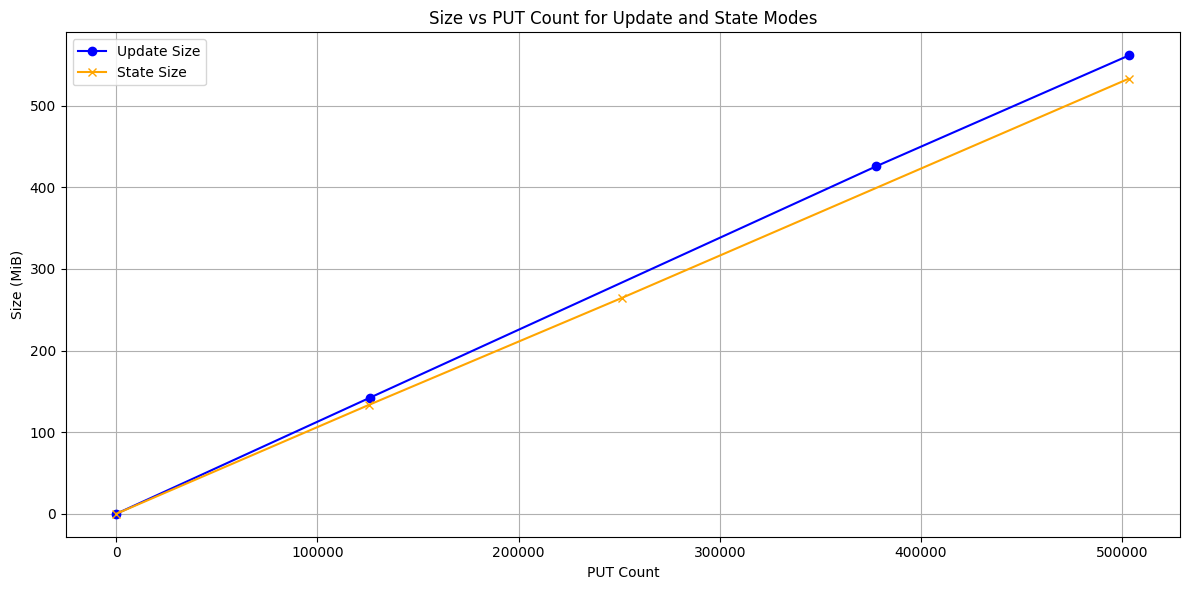

In [4]:
database = "postgres"
users = 10
rate = 10

diff_path = make_path(database, "diff", TIME, GPT, NOW, users, rate)
state_path = make_path(database, "state", TIME, GPT, NOW, users, rate)

diff_data = load_all_data(diff_path)
state_data = load_all_data(state_path)

# Plotting the data - I want the PUT count on the x-axis and the size on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(diff_data['ALL PUT'], diff_data['customer_total'], label='Update Size', color='blue', marker='o')
plt.plot(state_data['ALL PUT'], state_data['customer_total'], label='State Size', color='orange', marker='x')
plt.xlabel('PUT Count')
plt.ylabel('Size (MiB)')
plt.title('Size vs PUT Count for Update and State Modes')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

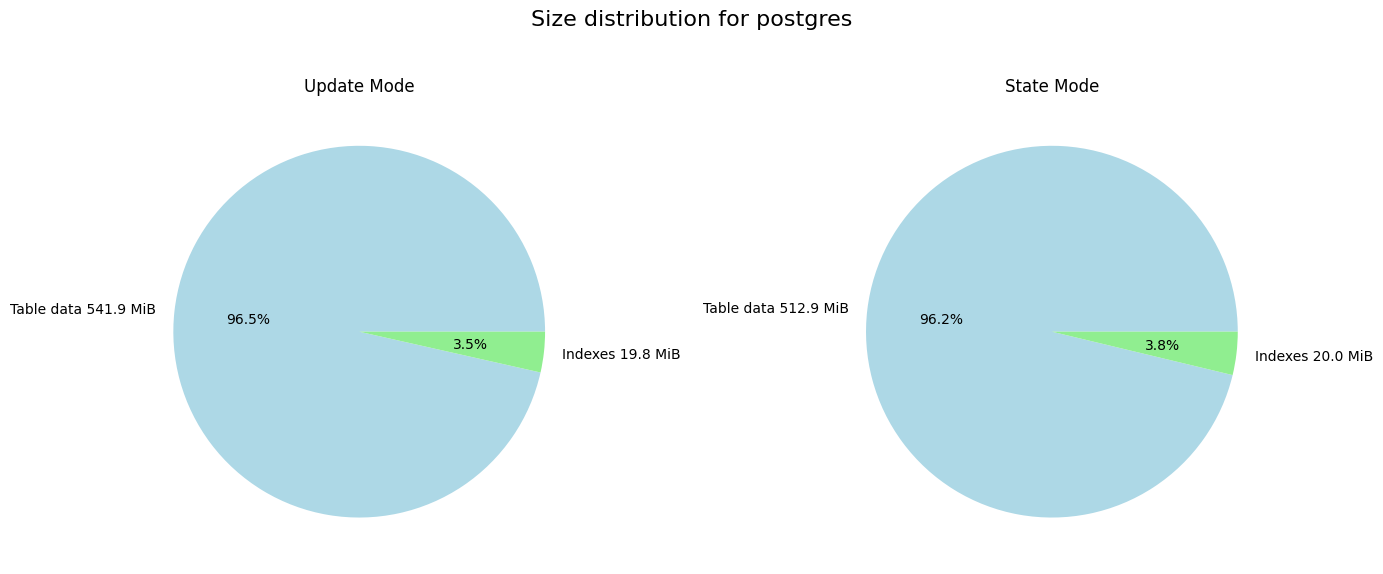

In [5]:
# Pie chart for space occupied

latest_diff = get_latest_data(diff_data)
latest_state = get_latest_data(state_data)


exclude = ['timestamp', 'ALL PUT']
latest_diff = latest_diff.drop(labels=exclude, axis=1, errors='ignore')
latest_state = latest_state.drop(labels=exclude, axis=1, errors='ignore')

# display(latest_diff)
# display(latest_state)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
pos = 0

for mode, data in zip(MODES, [latest_diff, latest_state]):

    total_size = data['customer_total'].iloc[0]
    indexes_size = data['customer_indexes'].iloc[0]
    data_size = data['customer_data'].iloc[0]

    # Diff mode plot
    axes[pos].pie([
        data_size,
        indexes_size], 
        labels=[
        f'Table data {data_size} MiB',
        f'Indexes {indexes_size} MiB'],
        autopct='%1.1f%%', colors=['lightblue', 'lightgreen'])
    axes[pos].set_title(f'{mode} Mode')
    axes[pos].grid(True)
    pos += 1

# General layout
fig.suptitle(f'Size distribution for {database}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

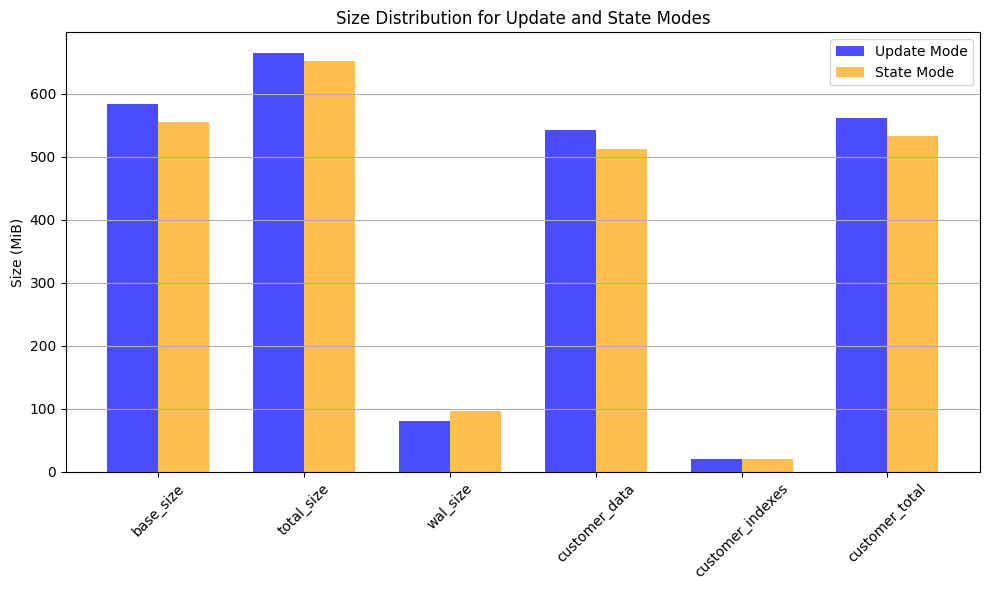

In [9]:
# Bar chart for size distribution
# I already have the latest_diff and latest_state dataframes with only the relevant columns

keep = [
    'base_size',
    'total_size',
    'wal_size',
    'customer_data',
    'customer_indexes',
    'customer_total',
]

latest_diff = latest_diff.filter(items=keep, axis=1)
latest_state = latest_state.filter(items=keep, axis=1)

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
x = range(len(latest_diff.columns))
# Bar positions
ax.bar(x, latest_diff.iloc[0], width=bar_width, label='Update Mode', color='blue', alpha=0.7)
ax.bar([i + bar_width for i in x], latest_state.iloc[0], width=bar_width, label='State Mode', color='orange', alpha=0.7)
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(latest_diff.columns, rotation=45)
ax.set_ylabel('Size (MiB)')
ax.set_title('Size Distribution for Update and State Modes')
ax.legend()
ax.grid(axis='y')
plt.tight_layout()
plt.show()

## XTDB2

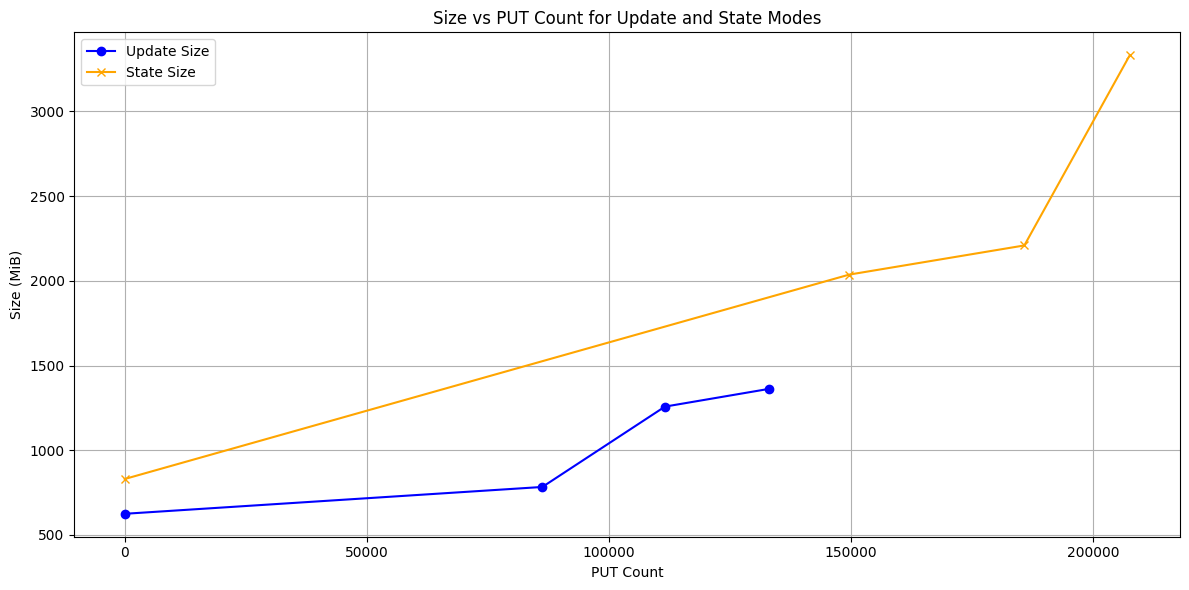

In [8]:
database = "xtdb2"
users = 10
rate = 10

diff_path = make_path(database, "diff", TIME, GPT, NOW, users, rate)
state_path = make_path(database, "state", TIME, GPT, NOW, users, rate)

diff_data = load_all_data(diff_path)
state_data = load_all_data(state_path)

# Plotting the data - I want the PUT count on the x-axis and the size on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(diff_data['ALL PUT'], diff_data['total_size'], label='Update Size', color='blue', marker='o')
plt.plot(state_data['ALL PUT'], state_data['total_size'], label='State Size', color='orange', marker='x')
plt.xlabel('PUT Count')
plt.ylabel('Size (MiB)')
plt.title('Size vs PUT Count for Update and State Modes')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

,buffers_size,log_size,total_size
4,0.01,260.97,260.98


,buffers_size,log_size,total_size
4,309.54,246.23,555.78


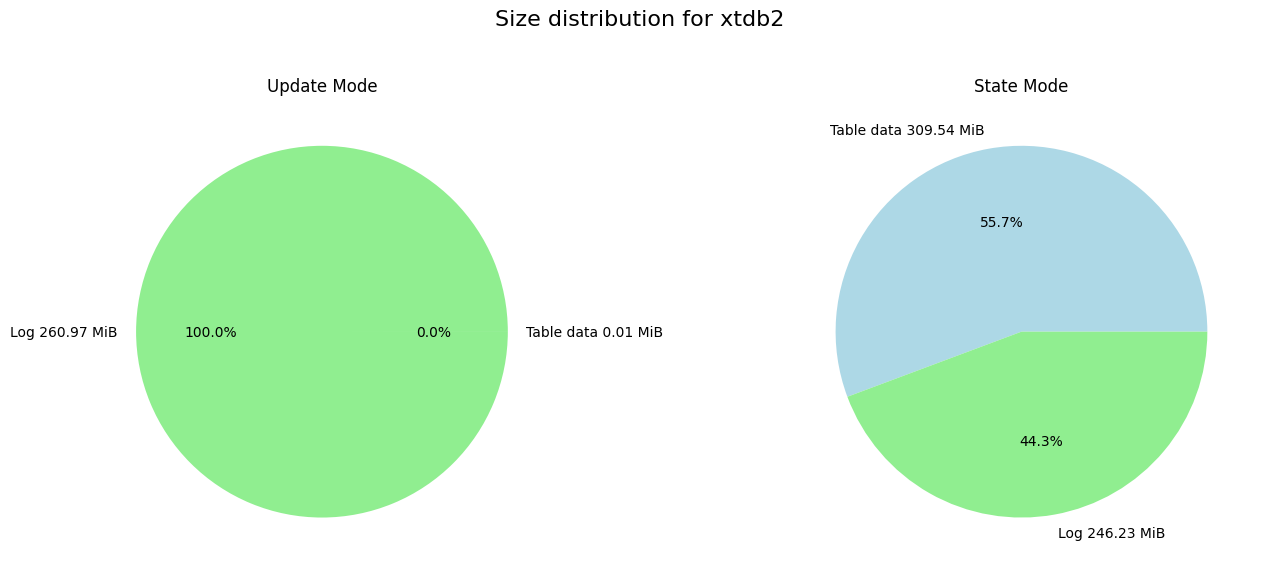

In [18]:
# Pie chart for space occupied

latest_diff = get_latest_data(diff_data)
latest_state = get_latest_data(state_data)


exclude = ['timestamp', 'ALL PUT']
latest_diff = latest_diff.drop(labels=exclude, axis=1, errors='ignore')
latest_state = latest_state.drop(labels=exclude, axis=1, errors='ignore')

display(latest_diff)
display(latest_state)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
pos = 0

for mode, data in zip(MODES, [latest_diff, latest_state]):

    total_size = data['total_size'].iloc[0]
    log_size = data['log_size'].iloc[0]
    buffer_size = data['buffers_size'].iloc[0]

    # Diff mode plot
    axes[pos].pie([
        buffer_size,
        log_size], 
        labels=[
        f'Table data {buffer_size} MiB',
        f'Log {log_size} MiB'],
        autopct='%1.1f%%', colors=['lightblue', 'lightgreen'])
    axes[pos].set_title(f'{mode} Mode')
    axes[pos].grid(True)
    pos += 1

# General layout
fig.suptitle(f'Size distribution for {database}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## TerminusDB

# 2. Compare average PUT and GET time in update vs state based 

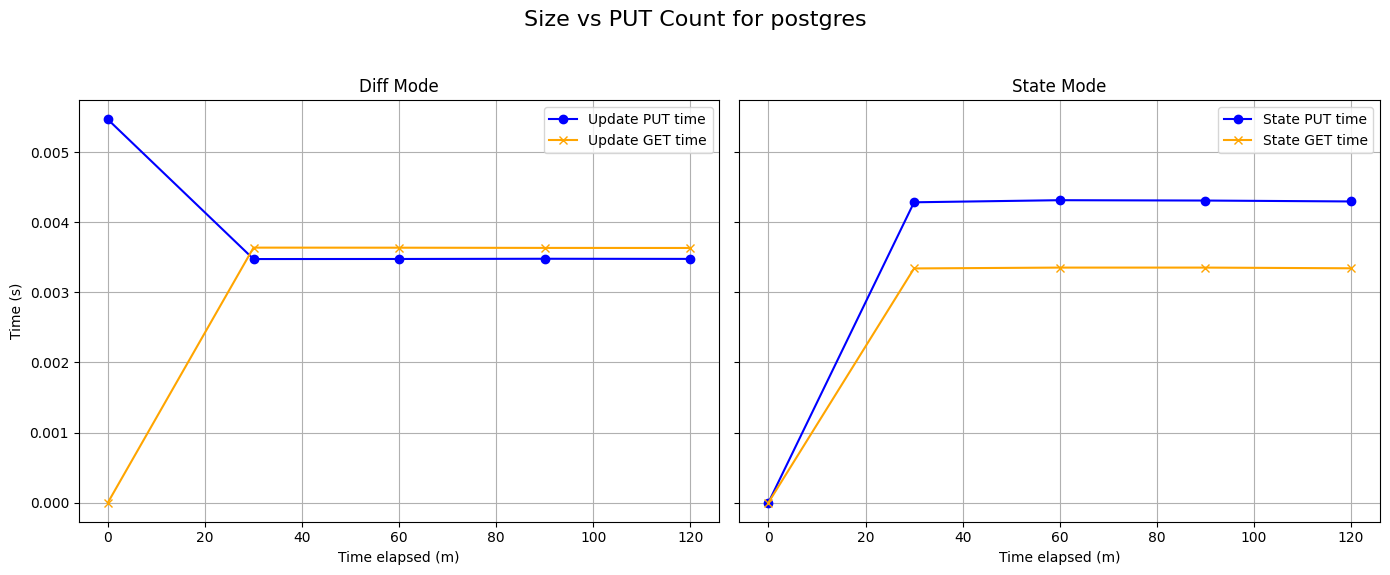

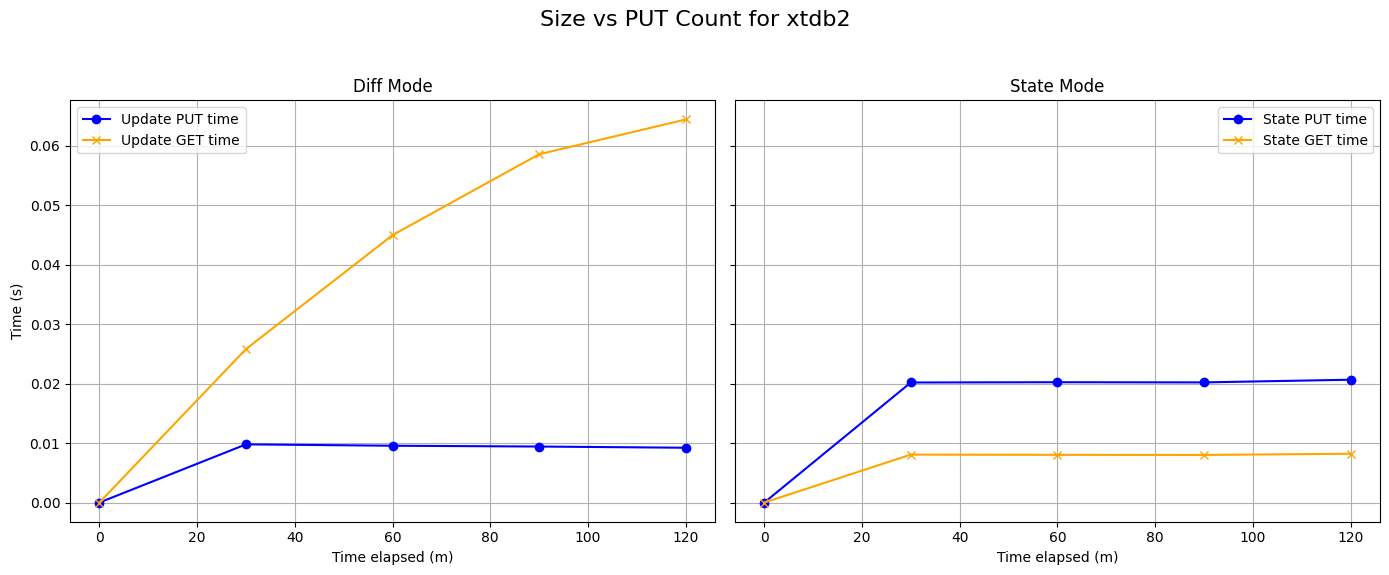

In [31]:
users = 1
rate = 10

for database in ALL_DATABASES:
    diff_path = make_path(database, "diff", TIME, GPT, NOW, users, rate)
    state_path = make_path(database, "state", TIME, GPT, NOW, users, rate)

    diff_data = load_time_data(diff_path)
    state_data = load_time_data(state_path)

    diff_data = add_elapsed_minutes_column(diff_data)
    state_data = add_elapsed_minutes_column(state_data)

    diff_put_times = diff_data[diff_data['label'] == 'ALL PUT']
    diff_get_times = diff_data[diff_data['label'] == 'ALL GET']
    state_put_times = state_data[state_data['label'] == 'ALL PUT']
    state_get_times = state_data[state_data['label'] == 'ALL GET']

    # Plotting the data - I want the PUT count on the x-axis and the size on the y-axis
      # Create subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # Diff mode plot
    axes[0].plot(diff_put_times['minutes'], diff_put_times['avg'], label='Update PUT time', color='blue', marker='o')
    axes[0].plot(diff_get_times['minutes'], diff_get_times['avg'], label='Update GET time', color='orange', marker='x')
    axes[0].set_title('Diff Mode')
    axes[0].set_xlabel('Time elapsed (m)')
    axes[0].set_ylabel('Time (s)')
    axes[0].legend()
    axes[0].grid(True)

    # State mode plot
    axes[1].plot(state_put_times['minutes'], state_put_times['avg'], label='State PUT time', color='blue', marker='o')
    axes[1].plot(state_get_times['minutes'], state_get_times['avg'], label='State GET time', color='orange', marker='x')
    axes[1].set_title('State Mode')
    axes[1].set_xlabel('Time elapsed (m)')
    axes[1].legend()
    axes[1].grid(True)

    # General layout
    fig.suptitle(f'Size vs PUT Count for {database}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# 3. Compare time distribution in databases

## Time distribution

Processing database: postgres


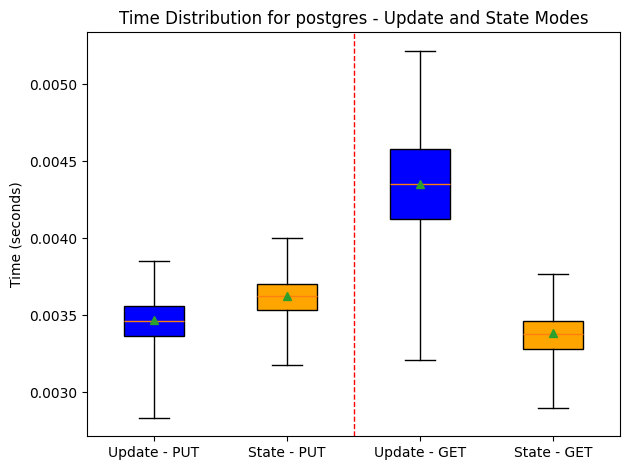

Processing database: xtdb2


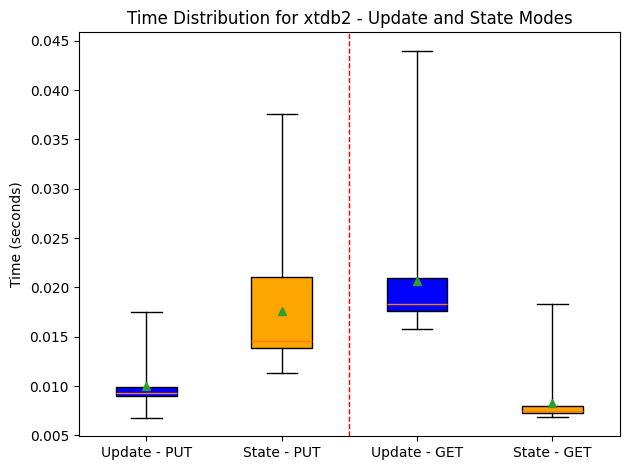

In [12]:
#From all the csv, get only the times correspondent to the latest timestamp
#Do an boxplot of the time distribution for each label (PUT, GET, etc.), use the median, 25 and 75 percentiles
#On the x-axis, put the label (PUT, GET, etc.)
#On the y-axis, put the time in seconds

users = 1
rate = 1


boxes_all = []

for database in ALL_DATABASES:
    boxes = []
    print(f"Processing database: {database}")

    # Construct paths for diff and state modes
    diff_path = make_path(database, "diff", TIME, GPT, NOW, users, rate)
    state_path = make_path(database, "state", TIME, GPT, NOW, users, rate)

    # Load CSVs
    diff_times = load_time_data(diff_path)
    state_times = load_time_data(state_path)

    # Filter for the latest timestamp
    state_filtered = get_latest_data(state_times)
    diff_filtered = get_latest_data(diff_times)

    fig, ax = plt.subplots()
    
    #Take the data for ALL PUT and ALL GET and build the boxes

    diff_put_times = diff_filtered[diff_filtered['label'] == 'ALL PUT']
    diff_get_times = diff_filtered[diff_filtered['label'] == 'ALL GET']
    state_put_times = state_filtered[state_filtered['label'] == 'ALL PUT']
    state_get_times = state_filtered[state_filtered['label'] == 'ALL GET']

    for label, times in zip(['Update - PUT', 'State - PUT', 'Update - GET', 'State - GET'], [diff_put_times, diff_get_times, state_put_times, state_get_times]):
        if not times.empty:
            bottom = times['min'].values[0]
            q1 = times['p25'].values[0]
            med = times['p50'].values[0]
            mean = times['avg'].values[0]
            q3 = times['p75'].values[0]
            top = times['p99'].values[0]
            boxes.append(make_box(f"{label}", bottom, q1, med, mean, q3, top))

    # Create boxplot
    bplots = ax.bxp(boxes, vert=True, patch_artist=True, showfliers=False, showmeans=True)
    ax.set_ylabel('Time (seconds)')
    ax.set_title(f'Time Distribution for {database} - Update and State Modes')
    ax.axvline(x=2.5, color='red', linestyle='--', linewidth=1)

    colors = ["blue", "orange", "blue", "orange"]
    for patch, clr in zip(bplots["boxes"], colors):
        patch.set_facecolor(clr)
    plt.tight_layout()
    plt.show()
    
    # Create boxes for diff and state
    

# 4. Updates and Gets from Current vs Past state

# 5. Increasing the Rate

Check if the database can keep with the expected troughput when the client number of rate of requests is increased